In [2]:
from preprocessing import load_folder_paths, load_dcm_datasets, get_volume
from scipy import ndimage
import matplotlib.pyplot as plt

paths = load_folder_paths()

v = get_volume(paths[3], extract_brain=True, correct_motion=True, spatial_downsampling_factor=2, temporal_downsampling_factor=1)

Loading /Users/simonma/Desktop/UniToBrain/MOL-062...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-062...
5 [0.488281, 0.488281]
Info: Downsampling detected (2x), adjusting morphology_shape_2d from (1, 3) to (1, 2)
Info: Downsampling detected (2x), adjusting remove_small_objects_size from 500 to 125


ic| label_count: array([846925,    781,    742,   1755,      5, 196396,    130,      4,
                          1562,      1,      2,     36,      1,      2,      4,      1,
                             1,     19,      1,     10,      1,      3,      2,      1,
                             2,      1,      1,      6,     41,     77,      1,     41,
                            16,      2,      3])
ic| volume_seq.max(): 160.0
    volume_seq.min(): 0.0
    volume_seq.dtype: dtype('float32')


get_3d_mask took 0.29050707817077637 seconds
Total time taken: 2.87 seconds
Average time taken per volume: 0.16 seconds
Reference volume: (16, 256, 256)
Registering volume 1
Registering slice 8 of 16
[2.94078334]
Registering volume 2
Registering slice 8 of 16
[3.82465916]
Registering volume 3
Registering slice 8 of 16
[3.67342954]
Registering volume 4
Registering slice 8 of 16
[16.3568223]
Registering volume 5
Registering slice 8 of 16
[44.15361502]
Registering volume 6
Registering slice 8 of 16
[77.72108006]
Registering volume 7
Registering slice 8 of 16
[83.90681796]
Registering volume 8
Registering slice 8 of 16
[54.30943334]
Registering volume 9
Registering slice 8 of 16
[29.34043974]
Registering volume 10
Registering slice 8 of 16
[20.25507886]
Registering volume 11
Registering slice 8 of 16
[14.55009914]
Registering volume 12
Registering slice 8 of 16
[12.56419917]
Registering volume 13
Registering slice 8 of 16
[14.32436538]
Registering volume 14
Registering slice 8 of 16
[13.85

In [9]:
import numpy as np
from scipy.linalg import svd, toeplitz
from scipy.integrate import trapz

In [3]:
from ipywidgets import interact, IntSlider

def overlay_volume_sequence_interactive(volume_seq):
    num_overlays = len(volume_seq) - 1
    nrows = max(1, int(num_overlays ** 0.5))
    ncols = (num_overlays + nrows - 1) // nrows
    print(f"{nrows=} {ncols=}")
    def plot_slice(slice_idx):

        fig, axes = plt.subplots(nrows, 
                                ncols, 
                                figsize=(5*ncols, 5*nrows),
                                squeeze=True)
        if nrows == 1:
            if ncols == 1:
                axes = [[axes]]
            else:
                axes = [axes]
        print(f"{axes=}")
        for i in range(num_overlays):
            ax = axes[i // ncols][i % ncols]
            print(f"{ax=}")
            ax.imshow(volume_seq[0][slice_idx], cmap="gray")
            ax.imshow(volume_seq[i+1][slice_idx], cmap="hot", alpha=0.5)
        plt.show(block=True)
    
    interact(
        plot_slice,
        slice_idx=IntSlider(
            min=0,
            max=len(volume_seq[0])-1, 
            step=1,
            value=0,
            description='Slice:'
        )
    )

def multi_vol_seq_interactive(volume_seqs, titles=None):
    """
    Interactive plot of multiple volume sequences using ipywidgets
    
    Parameters:
    - volume_seqs: List of 4D volume sequences to display
    - titles: Optional list of titles for each sequence
    """
    if titles is None:
        titles = [f"Volume {i+1}" for i in range(len(volume_seqs))]
        
    num_volumes = len(volume_seqs)
    nrows = int(num_volumes ** 0.5)
    ncols = (num_volumes + nrows - 1) // nrows
    
    def plot_volumes(time_idx, slice_idx):
        fig, axes = plt.subplots(nrows, ncols, 
                                figsize=(5*ncols, 5*nrows),
                                squeeze=True)
        if nrows == 1:
            if ncols == 1:
                axes = [[axes]]
            else:
                axes = [axes]
                
        for i, (volume_seq, title) in enumerate(zip(volume_seqs, titles)):
            row, col = i // ncols, i % ncols
            ax = axes[row][col]
            
            t = min(time_idx, len(volume_seq) - 1)
            s = min(slice_idx, len(volume_seq[t]) - 1)
            
            im = ax.imshow(volume_seq[t][s], cmap='magma')
            ax.set_title(title)
            plt.colorbar(im, ax=ax)
            
        plt.tight_layout()
        plt.show(block=True)
        
    max_time = max(len(vol) for vol in volume_seqs) - 1
    max_slice = max(len(vol[0]) for vol in volume_seqs) - 1
    
    interact(
        plot_volumes,
        time_idx=IntSlider(min=0, max=max_time, step=1, value=0, description='Time:'),
        slice_idx=IntSlider(min=0, max=max_slice, step=1, value=0, description='Slice:')
    )

multi_vol_seq_interactive([v])

interactive(children=(IntSlider(value=0, description='Time:', max=17), IntSlider(value=0, description='Slice:'…

In [3]:
import numpy as np
from scipy.linalg import svd
from scipy.integrate import trapz

def calculate_perfusion_maps(ct_slices, delta_t, aif_coords=None, reg_threshold=0.1, baseline_frames=2):
    """
    Calculate perfusion parameter maps using SVD-based deconvolution method
    
    Args:
        ct_slices: 3D numpy array of shape (time, height, width) - CT perfusion data in Hounsfield Units (HU)
        delta_t: Temporal resolution in seconds (time between frames)
        aif_coords: Tuple (x,y) specifying Arterial Input Function (AIF) location (optional)
        reg_threshold: Regularization threshold for SVD (0.1-0.3 typical)
        baseline_frames: Number of baseline frames for HU normalization
        
    Returns:
        cbf_map: Cerebral Blood Flow map (relative units)
        cbv_map: Cerebral Blood Volume map (relative units)
        mtt_map: Mean Transit Time map (seconds)
    """
    
    # Convert Hounsfield Units to contrast concentration
    baseline = np.mean(ct_slices[:baseline_frames], axis=0)
    concentration = ct_slices - baseline[None,...]  # Shape (time, height, width)
    
    # Automatically detect AIF if not provided
    if aif_coords is None:
        peak_values = np.max(concentration, axis=0)
        aif_mask = peak_values > 0.5*np.max(peak_values)
        aif_candidates = concentration[:,aif_mask]
        arrival_times = np.argmax(aif_candidates > 0.1*np.max(aif_candidates), axis=0)
        aif_idx = np.argmin(arrival_times)
        aif = aif_candidates[:,aif_idx]
    else:
        aif = concentration[:,aif_coords[0], aif_coords[1]]
    
    # Create convolution matrix from AIF
    n = len(aif)
    A = np.zeros((n, n))
    for i in range(n):
        A[i,:i+1] = aif[:i+1][::-1] * delta_t
    
    # Perform SVD and regularize
    U, s, Vh = svd(A, full_matrices=False)
    s_inv = np.zeros_like(s)
    s_inv[s > reg_threshold] = 1/s[s > reg_threshold]
    A_inv = (Vh.T @ np.diag(s_inv) @ U.T).T
    
    # Initialize parameter maps
    cbf_map = np.zeros(concentration.shape[1:])
    cbv_map = np.zeros_like(cbf_map)
    mtt_map = np.zeros_like(cbf_map)
    
    # Calculate parameters for each voxel
    for x in range(concentration.shape[1]):
        for y in range(concentration.shape[2]):
            C = concentration[:,x,y]
            
            # Calculate residue function
            R = A_inv @ C
            
            # Calculate perfusion parameters
            cbf = np.max(R)
            cbv = trapz(C, dx=delta_t) / trapz(aif, dx=delta_t)
            mtt = cbv / cbf if cbf > 0 else 0
            
            cbf_map[x,y] = cbf
            cbv_map[x,y] = cbv
            mtt_map[x,y] = mtt
    
    return cbf_map, cbv_map, mtt_map

/var/folders/bh/qf1v6xm50lz_nh8mfd1m_fgm0000gn/T/ipykernel_75710/1799199896.py:64: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  cbv = trapz(C, dx=delta_t) / trapz(aif, dx=delta_t)


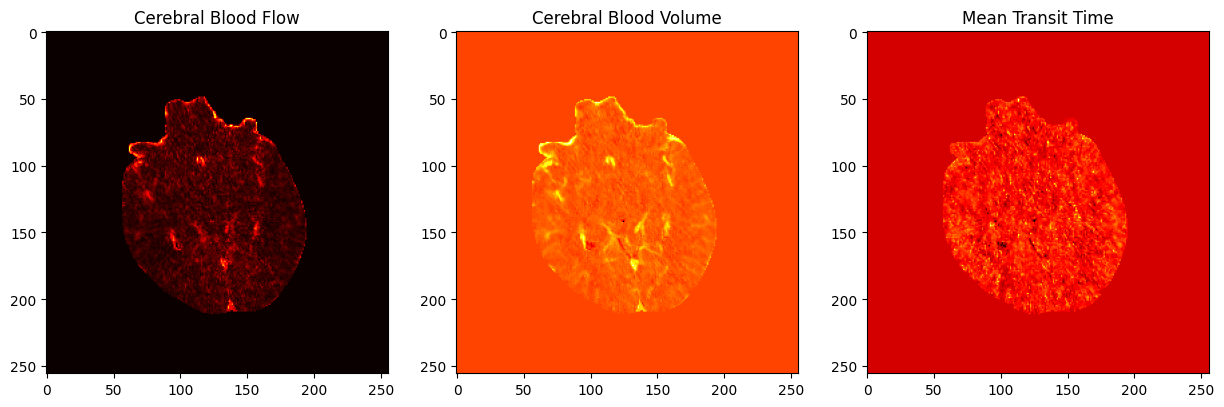

In [4]:
import matplotlib.pyplot as plt

cbf, cbv, mtt = calculate_perfusion_maps(v[:, 5, :, :], 2.8)

def plot_perfusion_maps(cbf, cbv, mtt):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(cbf, cmap="hot")
    axes[0].set_title("Cerebral Blood Flow")
    axes[1].imshow(cbv, cmap="hot")
    axes[1].set_title("Cerebral Blood Volume")
    axes[2].imshow(mtt, cmap="hot")
    axes[2].set_title("Mean Transit Time")
    plt.show()

plot_perfusion_maps(cbf, cbv, mtt)

In [5]:
import numpy as np
from scipy.linalg import toeplitz

def compute_perfusion_parameters(slice_data, delta_t=1.0, baseline_num=5):
    """
    Calculate perfusion parameter maps (CBF, CBV, MTT) from 4D perfusion CT data
    using SVD-based deconvolution method.
    
    Args:
        slice_data: 3D numpy array of shape (time, height, width) in HU
        delta_t: Time between consecutive samples in seconds
        baseline_num: Number of initial time points to use for baseline
        
    Returns:
        cbf_map: Cerebral Blood Flow map (height, width)
        cbv_map: Cerebral Blood Volume map (height, width)
        mtt_map: Mean Transit Time map (height, width)
    """
    # Ensure input is numpy array
    slice_data = np.asarray(slice_data)
    T, height, width = slice_data.shape
    
    # 1. Compute baseline and concentration curves
    baseline = np.mean(slice_data[:baseline_num, :, :], axis=0)
    C = slice_data - baseline  # (T, H, W)
    
    # 2. Automatic AIF selection
    # Find time-to-peak (TTP) and maximum concentration for each pixel
    max_concentration = np.max(C, axis=0)  # (H, W)
    ttp = np.argmax(C, axis=0)  # (H, W)
    
    # Select pixels with early TTP and high maximum concentration
    t_threshold = int(0.2 * T)  # 20% of total time points
    max_threshold = np.percentile(max_concentration, 95)  # Top 5%
    
    # Create mask for candidate AIF pixels
    aif_mask = (ttp <= t_threshold) & (max_concentration >= max_threshold)
    
    # If no pixels meet criteria, fall back to pixel with highest maximum
    if np.sum(aif_mask) == 0:
        aif_mask = (max_concentration == np.max(max_concentration))
    
    # Extract AIF curves and average them
    aif_curves = C[:, aif_mask]  # (T, num_aif_pixels)
    AIF = np.mean(aif_curves, axis=1)  # (T,)
    
    # 3. Construct convolution matrix A
    column = AIF * delta_t
    row = np.zeros(T)
    row[0] = column[0]
    A = toeplitz(column, row)  # (T, T)
    
    # 4. Compute SVD and pseudoinverse with truncation
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    threshold = 0.2 * S.max()  # Truncation threshold (adjust as needed)
    S_inv = np.zeros_like(S)
    S_inv[S > threshold] = 1 / S[S > threshold]
    A_pinv = Vh.T @ np.diag(S_inv) @ U.T  # (T, T)
    
    # 5. Initialize parameter maps
    cbf_map = np.zeros((height, width))
    cbv_map = np.zeros((height, width))
    mtt_map = np.zeros((height, width))
    
    # 6. Process each pixel
    for i in range(height):
        for j in range(width):
            # Get concentration-time curve for pixel (i,j)
            C_pixel = C[:, i, j]
            
            # Solve for residue function using pseudoinverse
            R = A_pinv @ C_pixel  # (T,)
            
            # Compute perfusion parameters
            cbf = np.max(R)
            cbv = np.sum(C_pixel) / np.sum(AIF)
            
            # Handle division by zero for MTT
            if cbf > 0:
                mtt = cbv / cbf
            else:
                mtt = 0.0
            
            cbf_map[i, j] = cbf
            cbv_map[i, j] = cbv
            mtt_map[i, j] = mtt
    
    return cbf_map, cbv_map, mtt_map

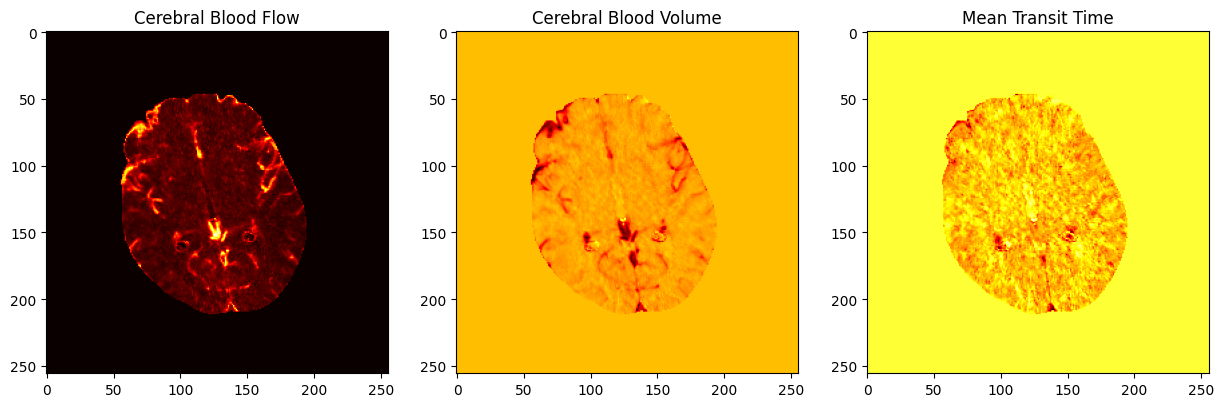

In [6]:
cbf, cbv, mtt = compute_perfusion_parameters(v[:, 6, :, :], delta_t=2.8)
plot_perfusion_maps(cbf, cbv, mtt)

In [7]:
from tqdm import tqdm
def compute_4d_perfusion_parameters(volume_data, delta_t=1.0, baseline_num=5, truncation_threshold=0.2):
    """
    Calculate perfusion parameter maps (CBF, CBV, MTT) from 4D perfusion CT volume
    using SVD-based deconvolution method with volume-wise AIF selection.
    
    Args:
        volume_data: 4D numpy array of shape (time, depth, height, width) in HU
        delta_t: Time between consecutive samples in seconds
        baseline_num: Number of initial time points to use for baseline
        truncation_threshold: SVD truncation threshold (fraction of max singular value)
        
    Returns:
        cbf_volume: Cerebral Blood Flow volume (depth, height, width)
        cbv_volume: Cerebral Blood Volume volume (depth, height, width)
        mtt_volume: Mean Transit Time volume (depth, height, width)
    """
    # Convert to numpy array and get dimensions
    volume_data = np.asarray(volume_data)
    T, D, H, W = volume_data.shape
    
    # Initialize output volumes
    cbf_volume = np.zeros((D, H, W))
    cbv_volume = np.zeros((D, H, W))
    mtt_volume = np.zeros((D, H, W))
    
    # 1. Volume-wise AIF selection ---------------------------------------------
    # Compute baseline for entire volume
    baseline_volume = np.mean(volume_data[:baseline_num], axis=0)
    C_volume = volume_data - baseline_volume[np.newaxis, ...]
    
    # Find maximum concentration across time for each voxel
    max_concentration = np.max(C_volume, axis=0)
    
    # Find time-to-peak (TTP) map for entire volume
    ttp_volume = np.argmax(C_volume, axis=0)
    
    # Select AIF candidates from entire volume
    t_threshold = int(0.2 * T)
    max_threshold = np.percentile(max_concentration, 99.9)  # Top 0.1%
    aif_mask = (ttp_volume <= t_threshold) & (max_concentration >= max_threshold)
    
    # Fallback if no candidates found
    if np.sum(aif_mask) == 0:
        aif_mask = (max_concentration == np.max(max_concentration))
    
    # Extract and average AIF curves from selected voxels
    aif_curves = C_volume[:, aif_mask]  # Shape becomes (T, num_selected_voxels)
    AIF = np.mean(aif_curves, axis=1)  # Corrected axis parameter
    
    # 2. Precompute SVD components --------------------------------------------
    # Build Toeplitz matrix from AIF
    column = AIF * delta_t
    row = np.zeros(T)
    row[0] = column[0]
    A = toeplitz(column, row)
    
    # Compute SVD and pseudoinverse
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    threshold = truncation_threshold * S[0]
    valid_singular = S > threshold
    S_inv = np.zeros_like(S)
    S_inv[valid_singular] = 1 / S[valid_singular]
    A_pinv = (Vh.T @ np.diag(S_inv) @ U.T).astype(np.float32)
    
    # 3. Process each slice ---------------------------------------------------
    for d in tqdm(range(D), desc="Processing slices"):
        C_slice = C_volume[:, d]  # (T, H, W)
        C_flat = C_slice.reshape(T, -1)
        R_flat = A_pinv @ C_flat
        R_slice = R_flat.reshape(T, H, W)
        
        cbf = np.max(R_slice, axis=0)
        aif_area = np.sum(AIF) * delta_t
        cbv = np.sum(C_slice, axis=0) * delta_t / aif_area
        
        with np.errstate(divide='ignore', invalid='ignore'):
            mtt = np.divide(cbv, cbf, where=(cbf > 0))
            mtt = np.nan_to_num(mtt, posinf=0, neginf=0)
        
        cbf_volume[d] = cbf
        cbv_volume[d] = cbv
        mtt_volume[d] = mtt
    
    return cbf_volume, cbv_volume, mtt_volume

Processing slices: 100%|██████████| 16/16 [00:00<00:00, 101.58it/s]


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

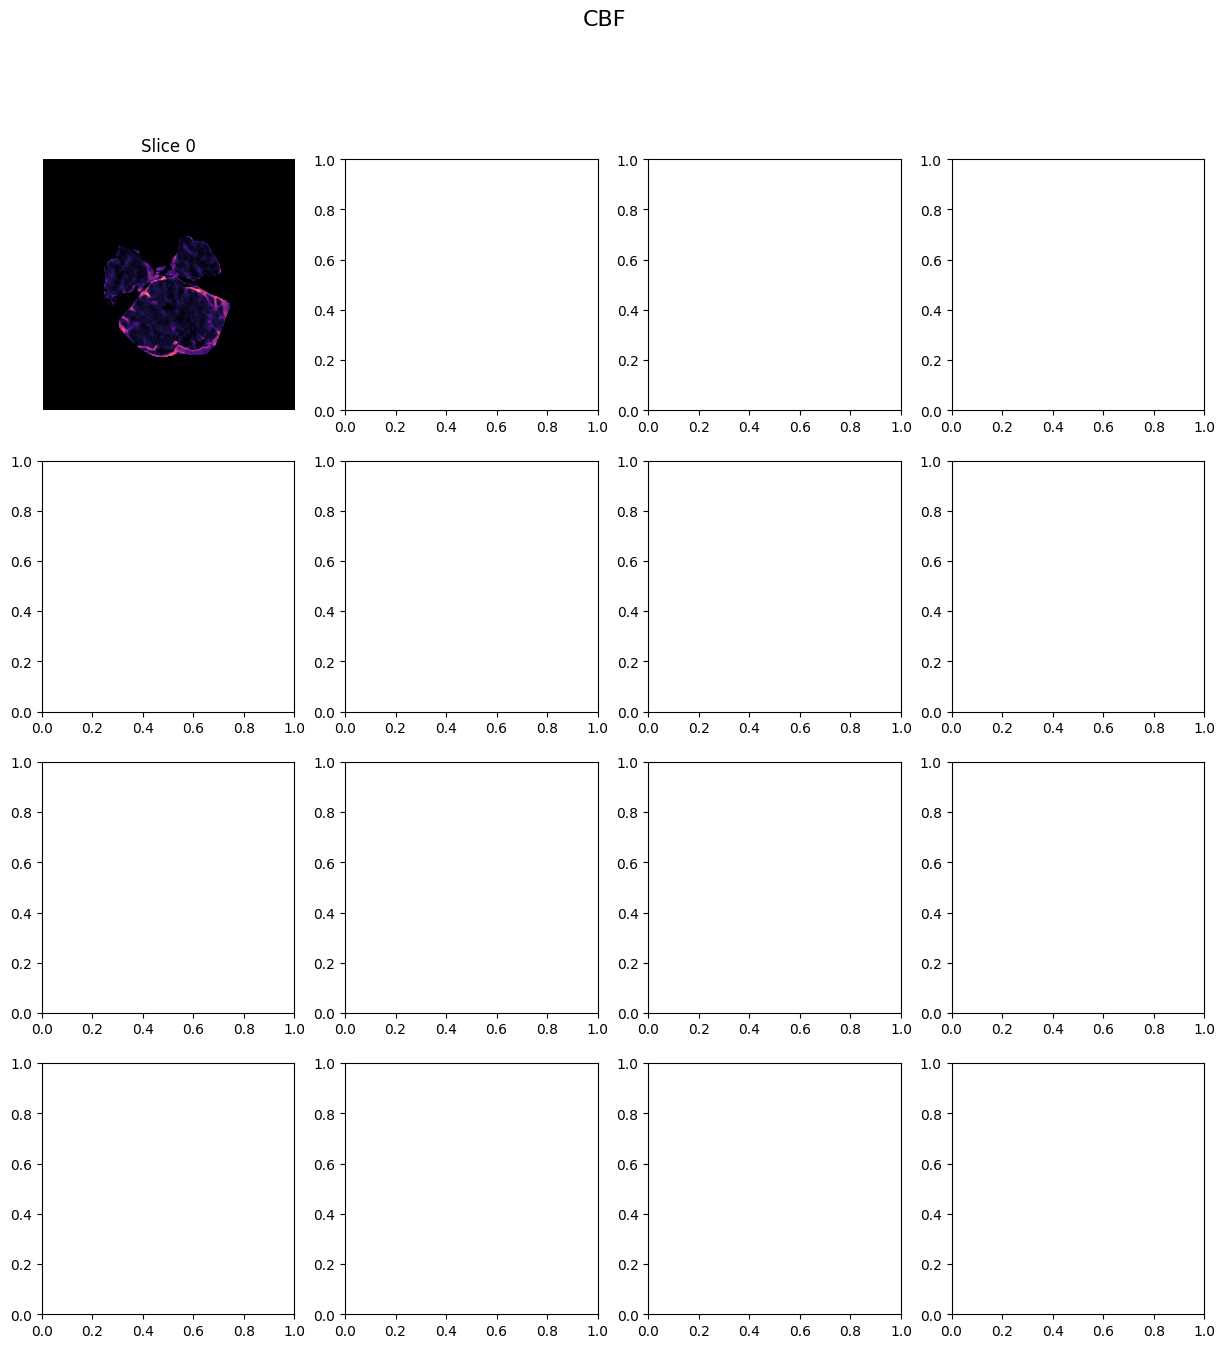

In [ ]:
cbf, cbv, mtt = compute_4d_perfusion_parameters(v, delta_t=2.8)
def plot_volume_slices(volume, title=None, cmap='magma'):
    """
    Plots all slices of a 3D volume in a rectangular grid arrangement.
    
    Parameters:
    - volume: 3D numpy array of shape (D, H, W)
    - title: Optional string for overall figure title
    - cmap: Colormap to use for plotting
    """
    D = volume.shape[0]
    vmin, vmax = np.min(volume), np.max(volume)

    # Calculate grid dimensions to arrange plots in a roughly square layout
    n_rows = int(np.ceil(np.sqrt(D)))
    n_cols = int(np.ceil(D / n_rows))
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    if title:
        fig.suptitle(title, fontsize=16)
    
    # Flatten axes array for easier iteration
    axes = axes.flatten()
    
    # Plot each slice
    for i in range(D):
        axes[i].imshow(volume[i], cmap=cmap, vmin=vmin, vmax=vmax)
        axes[i].axis('off')
        axes[i].set_title(f'Slice {i}')
    
    # Turn off any empty subplots
    for i in range(D, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Plot the perfusion parameters
plot_volume_slices(cbf, title='CBF')
# plot_volume_slices(cbv, title='CBV')
# plot_volume_slices(mtt, title='MTT')
